# SWB Computational Models

In [4]:
import numpy as np
import pandas as pd
from glob import glob
from numpy.linalg import vecdot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr, norm 
import scipy.stats as stats
from scipy.optimize import least_squares, minimize
from sklearn.metrics import r2_score
import random
import os
# from statannot import add_stat_annotation
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
import datetime
import statsmodels.api as sm
from joblib import Parallel, delayed
from tqdm import tqdm




In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [118]:
base_dir  = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
paper_dir = f'{base_dir}manuscript/'
behav_dir  = f'{paper_dir}data/behav/'
fig_dir   = f'{paper_dir}figs/behav/'
os.makedirs(fig_dir,exist_ok=True)

date = datetime.date.today().strftime('%m%d%Y')
print(date)


08262024


In [101]:
import sys
sys.path.append(f'{base_dir}swb_computational_modeling/swb_behav_models/scripts')
from SWB_modeling_utils import *

import sys
sys.path.append(f'{paper_dir}scripts/behav/')
from behav_utils import *
from swb_subj_behav import *


In [8]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

08262024


In [102]:
# load subj_ids of subj with preprocessed ephys data
subj_ids = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID.tolist()
# find subj without sufficient variation in mood ratings and drop from subj_ids list 
subj_ids = [subj_ids[idx] for idx in np.arange(0,len(subj_ids))[pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[2]).mood_var.isnull()]]
subj_ids


['MS002',
 'MS003',
 'MS009',
 'MS011',
 'MS015',
 'MS017',
 'MS019',
 'MS022',
 'MS024',
 'MS025',
 'MS026',
 'MS027',
 'MS029',
 'MS033',
 'MS035',
 'MS041',
 'MS043',
 'MS048',
 'DA8',
 'DA023',
 'DA037',
 'DA039']

# Load behav dfs

In [11]:
cont_vars=['SafeBet', 'LowBet', 'HighBet','Profit', 
                                                  'TotalProfit','GambleEV', 'TrialEV', 'CR',
                                                  'choiceEV','rpe', 'cf', 'max_cf', 'cpe', 'max_cpe',
                                                  'SafeBet_t1','LowBet_t1', 'HighBet_t1', 'Profit_t1',
                                                  'TotalProfit_t1','GambleEV_t1', 'TrialEV_t1','CR_t1', 
                                                  'choiceEV_t1', 'rpe_t1','cf_t1', 'max_cf_t1','cpe_t1', 'max_cpe_t1']

In [12]:
# load task_dfs into master list 
raw_behav = [pd.read_csv(f'{behav_dir}/{subj_id}_task_df.csv') for subj_id in subj_ids]
# raw_behav

In [13]:
all_behav,drops = format_all_behav(raw_behav,mood=True,drops_data=True)

In [14]:
all_behav

,subj_id,bdi,bdi_thresh,Round,RT,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,ChoicePos,...,choiceEV_t1,rpe_t1,res_type_t1,cf_t1,max_cf_t1,cpe_t1,max_cpe_t1,keep_epoch,keep_epoch_t1,CpeOnset
0,MS002,14,low,1,2.059852,513.380590,513.390239,515.450091,515.457173,right,...,-0.744531,-0.549717,gamble_bad,-0.147087,0.020647,-0.452536,-0.456974,keep,keep,517.450091
1,MS002,14,low,2,1.954564,522.640856,522.641563,524.596127,526.627092,right,...,1.066486,0.948000,gamble_good,0.280945,0.020647,0.724697,0.717387,keep,keep,526.596127
2,MS002,14,low,3,1.583462,531.174799,531.175599,532.759061,534.780269,right,...,-0.090361,-0.008716,safe_good,-0.452824,-0.382685,0.431913,0.324445,keep,keep,534.759061
3,MS002,14,low,4,2.491611,545.592613,545.593355,548.084966,548.092333,left,...,0.763502,0.697431,gamble_good,0.342093,0.020647,0.395315,0.520916,keep,keep,550.084966
4,MS002,14,low,5,1.768936,555.337336,555.345720,557.114656,559.135069,left,...,-0.090361,-0.008716,safe_good,-0.636266,-0.533934,0.614903,0.458402,keep,keep,559.114656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,DA039,22,high,146,1.079701,2259.827656,2259.828749,2260.908450,2262.926195,right,...,-0.130463,0.003871,safe_good,-1.304944,-0.962934,0.971952,0.645162,keep,keep,2262.908450
3296,DA039,22,high,147,1.837272,2267.502359,2267.534059,2269.371331,2269.377701,right,...,-0.130463,0.003871,safe_bad,0.373087,0.229608,-0.314481,-0.176344,keep,keep,2271.371331
3297,DA039,22,high,148,4.030006,2282.349445,2282.350662,2286.380667,2286.389886,left,...,-0.130463,0.003871,safe_bad,0.381872,0.235851,-0.321216,-0.180645,keep,keep,2288.380667
3298,DA039,22,high,149,3.167144,2293.040983,2293.042042,2296.209186,2296.218136,left,...,-1.648269,-1.125038,gamble_bad,-0.426394,-0.026383,-1.385385,-1.075270,keep,keep,2298.209186


In [15]:
behav_vars = ['SafeBet', 'LowBet', 'HighBet','Profit', 'TotalProfit', 'GambleEV', 'TrialEV', 'CR', 'choiceEV', 
              'rpe', 'cf', 'max_cf', 'cpe', 'max_cpe']

In [16]:
mood_model_data = []
for subj_id in subj_ids:
    subj_task_df = all_behav[all_behav.subj_id == subj_id].reset_index(drop=True)
    subj_mood_df = pd.read_csv(f'{behav_dir}/{subj_id}_mood_df.csv')
    subj_mood_df['norm_mood'] = norm_zscore(subj_mood_df.Rating)
    # t-1 trial data
    t1_task_epochs = subj_task_df.loc[subj_mood_df.epoch_t1_idx]
    # print()
    # t-2 trial data
    t2_task_epochs = subj_task_df.loc[subj_mood_df.epoch_t2_idx]

    # t-3 trial data
    t3_task_epochs = subj_task_df.loc[subj_mood_df.epoch_t3_idx]

    for var in behav_vars:
        var_t1_data = t1_task_epochs[var].values
        var_t1 = '_'.join([var,'t1'])
        subj_mood_df[var_t1] = var_t1_data

        var_t2_data = t2_task_epochs[var].values
        var_t2 = '_'.join([var,'t2'])
        subj_mood_df[var_t2] = var_t2_data
    
        var_t3 = '_'.join([var,'t3'])
        var_t3_data = t3_task_epochs[var].values
        subj_mood_df[var_t3] = var_t3_data
    
    mood_model_data.append(subj_mood_df)
mood_model_data = pd.concat(mood_model_data).reset_index(drop=True)

In [17]:
mood_model_data

,subj_id,bdi,bdi_thresh,Round,Rating,RatingOnset,RT,Round_t1_idx,Round_t2_idx,Round_t3_idx,...,cf_t3,max_cf_t1,max_cf_t2,max_cf_t3,cpe_t1,cpe_t2,cpe_t3,max_cpe_t1,max_cpe_t2,max_cpe_t3
0,MS002,14,low,4,70.0,539.343131,5.210698,3,2,1,...,0.377061,0.014060,0.014060,0.301952,0.730687,-0.446290,-0.397504,0.722988,-0.453254,-0.283303
1,MS002,14,low,7,70.0,572.673634,3.332630,6,5,4,...,-0.461238,-0.541520,0.014060,-0.389998,0.620917,0.401377,0.437967,0.463589,0.526203,0.329417
2,MS002,14,low,10,69.0,605.109393,3.499831,9,8,7,...,-0.338859,1.125221,-0.137462,0.014060,-0.720715,0.133051,-0.592650,-1.504269,0.105797,-0.694764
3,MS002,14,low,13,71.0,638.791836,3.884104,12,11,10,...,0.211849,0.468626,0.014060,0.493879,-0.598749,0.340394,-0.232849,-0.430892,0.347306,-0.453254
4,MS002,14,low,16,71.0,671.977904,4.250371,15,14,13,...,0.028280,-0.743549,0.524184,0.014060,0.864850,-0.415799,-0.415799,1.313346,-0.480089,-0.296720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,DA039,22,high,139,45.0,2176.828649,2.673696,138,137,136,...,0.457063,NaN,-0.211115,0.557498,NaN,0.157063,-0.386461,NaN,0.130483,-0.413105
1096,DA039,22,high,142,45.0,2211.211948,2.961470,141,140,139,...,-0.006340,0.419258,-1.239618,-0.045227,-0.326069,0.917996,-0.144895,-0.315337,0.623232,-0.065052
1097,DA039,22,high,145,55.0,2246.799223,3.347751,144,143,142,...,NaN,-0.741955,-0.045227,NaN,0.555647,0.942153,NaN,0.388590,0.834411,NaN
1098,DA039,22,high,148,68.0,2276.912826,4.403968,147,146,145,...,0.379829,-0.874665,-0.045227,0.728915,0.881761,0.748900,-0.326069,0.599768,0.670161,-0.534337


In [18]:
mood_model_data.to_csv(f'{paper_dir}/mood_model_data_{date}.csv')

# Feature Selection for Mood Models

In [19]:
behav_vars = ['SafeBet', 'LowBet', 'HighBet','Profit', 'TotalProfit', 'GambleEV', 'TrialEV', 'CR', 'choiceEV', 
              'rpe', 'cf', 'max_cf', 'cpe', 'max_cpe']

In [20]:
mood_model_data.fillna(0, inplace=True)

In [21]:
mood_model_data

,subj_id,bdi,bdi_thresh,Round,Rating,RatingOnset,RT,Round_t1_idx,Round_t2_idx,Round_t3_idx,...,cf_t3,max_cf_t1,max_cf_t2,max_cf_t3,cpe_t1,cpe_t2,cpe_t3,max_cpe_t1,max_cpe_t2,max_cpe_t3
0,MS002,14,low,4,70.0,539.343131,5.210698,3,2,1,...,0.377061,0.014060,0.014060,0.301952,0.730687,-0.446290,-0.397504,0.722988,-0.453254,-0.283303
1,MS002,14,low,7,70.0,572.673634,3.332630,6,5,4,...,-0.461238,-0.541520,0.014060,-0.389998,0.620917,0.401377,0.437967,0.463589,0.526203,0.329417
2,MS002,14,low,10,69.0,605.109393,3.499831,9,8,7,...,-0.338859,1.125221,-0.137462,0.014060,-0.720715,0.133051,-0.592650,-1.504269,0.105797,-0.694764
3,MS002,14,low,13,71.0,638.791836,3.884104,12,11,10,...,0.211849,0.468626,0.014060,0.493879,-0.598749,0.340394,-0.232849,-0.430892,0.347306,-0.453254
4,MS002,14,low,16,71.0,671.977904,4.250371,15,14,13,...,0.028280,-0.743549,0.524184,0.014060,0.864850,-0.415799,-0.415799,1.313346,-0.480089,-0.296720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,DA039,22,high,139,45.0,2176.828649,2.673696,138,137,136,...,0.457063,0.000000,-0.211115,0.557498,0.000000,0.157063,-0.386461,0.000000,0.130483,-0.413105
1096,DA039,22,high,142,45.0,2211.211948,2.961470,141,140,139,...,-0.006340,0.419258,-1.239618,-0.045227,-0.326069,0.917996,-0.144895,-0.315337,0.623232,-0.065052
1097,DA039,22,high,145,55.0,2246.799223,3.347751,144,143,142,...,0.000000,-0.741955,-0.045227,0.000000,0.555647,0.942153,0.000000,0.388590,0.834411,0.000000
1098,DA039,22,high,148,68.0,2276.912826,4.403968,147,146,145,...,0.379829,-0.874665,-0.045227,0.728915,0.881761,0.748900,-0.326069,0.599768,0.670161,-0.534337


In [22]:
behav_vars = ['SafeBet', 'LowBet', 'HighBet','Profit', 'TotalProfit', 'GambleEV', 'TrialEV', 'CR', 'choiceEV', 
              'rpe', 'cf', 'max_cf', 'cpe', 'max_cpe']

In [23]:
corr_info = []
for var in behav_vars:
    var_id = '_'.join([var,'t1'])
    model = sm.OLS(mood_model_data.cpe_t1,sm.add_constant(mood_model_data[var_id])).fit()
    corr_info.append((var,model.params[var_id],model.pvalues[var_id]))

In [24]:
0.05/len(corr_info)

0.0035714285714285718

In [25]:
corr_info

[('SafeBet', np.float64(0.03254541329152914), np.float64(0.2798887816993408)),
 ('LowBet', np.float64(-0.015429314411614926), np.float64(0.6144174946014509)),
 ('HighBet', np.float64(0.08190090745575168), np.float64(0.00741820061961597)),
 ('Profit',
  np.float64(0.6139999699706611),
  np.float64(1.237796660863825e-114)),
 ('TotalProfit',
  np.float64(0.11645601294026896),
  np.float64(8.425140412141438e-05)),
 ('GambleEV',
  np.float64(0.04321763132788978),
  np.float64(0.16090013396319447)),
 ('TrialEV', np.float64(0.03981868828687091), np.float64(0.19248222472244217)),
 ('CR', np.float64(-0.11472525437750632), np.float64(0.0003463813426849417)),
 ('choiceEV',
  np.float64(0.22166431329736686),
  np.float64(1.2540315768321373e-13)),
 ('rpe', np.float64(0.7024840071122461), np.float64(4.672055377004534e-165)),
 ('cf', np.float64(-0.492890423478433), np.float64(1.6479205163267695e-64)),
 ('max_cf',
  np.float64(-0.7534550510380181),
  np.float64(2.2398478882295385e-198)),
 ('cpe', np.f

In [26]:
main_var = 'cpe'
iter_vars = ['SafeBet','LowBet','HighBet','GambleEV','TrialEV','TotalProfit']

var_combos = [[v,main_var] for v in iter_vars]

for i in range(1,len(iter_vars)-1):
    iter_list = [list(tup)+[main_var] for tup in list(itertools.combinations(iter_vars,i+1))]
    var_list  = []
    for iter in iter_list:
        if 'GambleEV' in iter:
            if 'TrialEV' in iter:
                continue
            elif 'HighBet' in iter:
                continue
            elif 'LowBet' in iter:
                continue
            else:
                var_list.append(iter)

        elif 'TrialEV' in iter:
            if 'GambleEV' in iter:
                continue
            elif 'HighBet' in iter:
                continue
            elif 'LowBet' in iter:
                continue
            elif 'SafeBet' in iter:
                continue
            else:
                var_list.append(iter)
        else:
            var_list.append(iter)
    var_combos.extend(var_list)


var_combos

[['SafeBet', 'cpe'],
 ['LowBet', 'cpe'],
 ['HighBet', 'cpe'],
 ['GambleEV', 'cpe'],
 ['TrialEV', 'cpe'],
 ['TotalProfit', 'cpe'],
 ['SafeBet', 'LowBet', 'cpe'],
 ['SafeBet', 'HighBet', 'cpe'],
 ['SafeBet', 'GambleEV', 'cpe'],
 ['SafeBet', 'TotalProfit', 'cpe'],
 ['LowBet', 'HighBet', 'cpe'],
 ['LowBet', 'TotalProfit', 'cpe'],
 ['HighBet', 'TotalProfit', 'cpe'],
 ['GambleEV', 'TotalProfit', 'cpe'],
 ['TrialEV', 'TotalProfit', 'cpe'],
 ['SafeBet', 'LowBet', 'HighBet', 'cpe'],
 ['SafeBet', 'LowBet', 'TotalProfit', 'cpe'],
 ['SafeBet', 'HighBet', 'TotalProfit', 'cpe'],
 ['SafeBet', 'GambleEV', 'TotalProfit', 'cpe'],
 ['LowBet', 'HighBet', 'TotalProfit', 'cpe'],
 ['SafeBet', 'LowBet', 'HighBet', 'TotalProfit', 'cpe']]

In [27]:
control_var = 'rpe'
control_vars = ['SafeBet','LowBet','HighBet','GambleEV','TrialEV','TotalProfit']

control_combos = [[v,control_var] for v in control_vars]

for i in range(1,len(control_vars)-1):
    iter_list = [list(tup)+[control_var] for tup in list(itertools.combinations(control_vars,i+1))]
    var_list  = []
    for iter in iter_list:
        if 'GambleEV' in iter:
            if 'TrialEV' in iter:
                continue
            elif 'HighBet' in iter:
                continue
            elif 'LowBet' in iter:
                continue
            else:
                var_list.append(iter)

        elif 'TrialEV' in iter:
            if 'GambleEV' in iter:
                continue
            elif 'HighBet' in iter:
                continue
            elif 'LowBet' in iter:
                continue
            elif 'SafeBet' in iter:
                continue
            else:
                var_list.append(iter)
        else:
            var_list.append(iter)
    control_combos.extend(var_list)

control_combos

[['SafeBet', 'rpe'],
 ['LowBet', 'rpe'],
 ['HighBet', 'rpe'],
 ['GambleEV', 'rpe'],
 ['TrialEV', 'rpe'],
 ['TotalProfit', 'rpe'],
 ['SafeBet', 'LowBet', 'rpe'],
 ['SafeBet', 'HighBet', 'rpe'],
 ['SafeBet', 'GambleEV', 'rpe'],
 ['SafeBet', 'TotalProfit', 'rpe'],
 ['LowBet', 'HighBet', 'rpe'],
 ['LowBet', 'TotalProfit', 'rpe'],
 ['HighBet', 'TotalProfit', 'rpe'],
 ['GambleEV', 'TotalProfit', 'rpe'],
 ['TrialEV', 'TotalProfit', 'rpe'],
 ['SafeBet', 'LowBet', 'HighBet', 'rpe'],
 ['SafeBet', 'LowBet', 'TotalProfit', 'rpe'],
 ['SafeBet', 'HighBet', 'TotalProfit', 'rpe'],
 ['SafeBet', 'GambleEV', 'TotalProfit', 'rpe'],
 ['LowBet', 'HighBet', 'TotalProfit', 'rpe'],
 ['SafeBet', 'LowBet', 'HighBet', 'TotalProfit', 'rpe']]

In [28]:
control_var2 = 'Profit'

control_combos2 = [[v,control_var2] for v in control_vars]

for i in range(1,len(control_vars)-1):
    iter_list = [list(tup)+[control_var2] for tup in list(itertools.combinations(control_vars,i+1))]
    var_list  = []
    for iter in iter_list:
        if 'GambleEV' in iter:
            if 'TrialEV' in iter:
                continue
            elif 'HighBet' in iter:
                continue
            elif 'LowBet' in iter:
                continue
            else:
                var_list.append(iter)

        elif 'TrialEV' in iter:
            if 'GambleEV' in iter:
                continue
            elif 'HighBet' in iter:
                continue
            elif 'LowBet' in iter:
                continue
            elif 'SafeBet' in iter:
                continue
            else:
                var_list.append(iter)
        else:
            var_list.append(iter)
    control_combos2.extend(var_list)

control_combos2

[['SafeBet', 'Profit'],
 ['LowBet', 'Profit'],
 ['HighBet', 'Profit'],
 ['GambleEV', 'Profit'],
 ['TrialEV', 'Profit'],
 ['TotalProfit', 'Profit'],
 ['SafeBet', 'LowBet', 'Profit'],
 ['SafeBet', 'HighBet', 'Profit'],
 ['SafeBet', 'GambleEV', 'Profit'],
 ['SafeBet', 'TotalProfit', 'Profit'],
 ['LowBet', 'HighBet', 'Profit'],
 ['LowBet', 'TotalProfit', 'Profit'],
 ['HighBet', 'TotalProfit', 'Profit'],
 ['GambleEV', 'TotalProfit', 'Profit'],
 ['TrialEV', 'TotalProfit', 'Profit'],
 ['SafeBet', 'LowBet', 'HighBet', 'Profit'],
 ['SafeBet', 'LowBet', 'TotalProfit', 'Profit'],
 ['SafeBet', 'HighBet', 'TotalProfit', 'Profit'],
 ['SafeBet', 'GambleEV', 'TotalProfit', 'Profit'],
 ['LowBet', 'HighBet', 'TotalProfit', 'Profit'],
 ['SafeBet', 'LowBet', 'HighBet', 'TotalProfit', 'Profit']]

In [29]:
control_models = control_combos + control_combos2

# Mood Models
- run cpe models + save outputs 

In [30]:
model_list = ['_'.join(vars) for vars in var_combos]
model_list

['SafeBet_cpe',
 'LowBet_cpe',
 'HighBet_cpe',
 'GambleEV_cpe',
 'TrialEV_cpe',
 'TotalProfit_cpe',
 'SafeBet_LowBet_cpe',
 'SafeBet_HighBet_cpe',
 'SafeBet_GambleEV_cpe',
 'SafeBet_TotalProfit_cpe',
 'LowBet_HighBet_cpe',
 'LowBet_TotalProfit_cpe',
 'HighBet_TotalProfit_cpe',
 'GambleEV_TotalProfit_cpe',
 'TrialEV_TotalProfit_cpe',
 'SafeBet_LowBet_HighBet_cpe',
 'SafeBet_LowBet_TotalProfit_cpe',
 'SafeBet_HighBet_TotalProfit_cpe',
 'SafeBet_GambleEV_TotalProfit_cpe',
 'LowBet_HighBet_TotalProfit_cpe',
 'SafeBet_LowBet_HighBet_TotalProfit_cpe']

In [110]:
model_inputs = {}

for vars in var_combos:
    model_id = '_'.join(vars)
    model_data_vars = ['norm_mood']
    for v in vars:
        model_data_vars.extend(['_'.join([v,'t1']),'_'.join([v,'t2']),'_'.join([v,'t3'])])
    model_inputs[model_id] = model_data_vars




In [111]:
np.random.uniform(-1,1,2)

array([ 0.57005918, -0.15888818])

In [112]:
model_results = {f'{model}':{f'{subj_id}':{} for subj_id in subj_ids} for model in model_inputs.keys()}
gamma_bounds  = [(0.00001,1)]
n_inits = 5

for model_id in list(model_inputs.keys()):
    n_regs       = len(model_id.split('_'))
    param_bounds = gamma_bounds + [(-2,2) for reg_num in range(n_regs+1)]
    gam_inits    = np.array([np.random.uniform(0,1) for n in range(n_inits)])
    var_inits    = [np.random.uniform(-1,1,n_inits) for n in range(n_regs+1)]

    for subj_id in subj_ids:
        subj_df = mood_model_data[mood_model_data.subj_id == subj_id][model_inputs[model_id]]
        var_init_grid  = itertools.product(*np.vstack((gam_inits,var_inits))) 
        subj_model_fit = parallel_glm_fit(min_negll_glm,fit_swb_glm,var_init_grid,param_bounds,subj_df)
        model_results[model_id][subj_id] = subj_model_fit

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 610 out of 625 | elapsed:    5.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:

In [119]:
f'{paper_dir}mood_model_results_dict.pkl'

'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/manuscript/mood_model_results_dict.pkl'

In [120]:
import pickle
pickle.dump(model_results,open(f'{paper_dir}mood_model_results_dict.pkl','wb'))
# # # create a binary pickle file 
# pickle.dump(all_subj_metadata,
#             open(f'{save_dir}all_subj_metadata.pkl',"wb"))

In [114]:
model_results

{'SafeBet_cpe': {'MS002': {'best_result':   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
     success: True
      status: 0
         fun: 34.50380825794582
           x: [ 8.758e-01  4.670e-04  1.228e-01  1.446e-01]
         nit: 21
         jac: [ 0.000e+00 -1.421e-06  1.421e-06  7.105e-07]
        nfev: 120
        njev: 24
    hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>,
   'subj_dict': {'params': array([8.75754893e-01, 4.66993917e-04, 1.22772974e-01, 1.44618882e-01]),
    'reg_list': ['SafeBet_t1',
     'SafeBet_t2',
     'SafeBet_t3',
     'cpe_t1',
     'cpe_t2',
     'cpe_t3'],
    'pred_mood': array([ 2.88049107e-02,  2.66000628e-01, -2.34794551e-01,  1.72657055e-03,
            3.73364409e-02, -2.57488306e-01, -1.97211012e-02,  2.09697347e-01,
           -7.33347897e-02,  2.12098902e-01, -5.99083264e-02,  1.20959569e-01,
            1.91152611e-03, -1.47274487e-04, -9.39630540e-03, -6.93533230e-03,
            5.07287874e-03, -5.18968893e-02,  3.8889964

In [472]:
model_results = {f'{model}':{f'{subj_id}':{} for subj_id in subj_ids} for model in model_inputs.keys()}
gamma_bounds = [(0.0001,1)]
n_inits = 2

for model in model_inputs.keys():
    model_data   = model_inputs[model]
    reg_list     = model.split('_')
    param_bounds = gamma_bounds + [(-10,10) for reg_num in range(len(reg_list)+1)]
    gam_inits    = np.array([np.random.uniform(0,1) for n in range(n_inits)])
    var_inits    = [np.random.uniform(-1,1,n_inits) for n in range(len(reg_list)+1)]

    for subj_id in subj_ids:
        subj_data      = model_inputs[model][model_inputs[model].subj_id == subj_id]
        var_init_grid  = itertools.product(*np.vstack((gam_inits,var_inits)))
        subj_model_fit = parallel_glm_fit(min_negll_glm,fit_swb_glm,var_init_grid,param_bounds,subj_data,reg_list)
        model_results[model][subj_id] = subj_model_fit





[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    5.4s remaining:    7.0s
[Parallel(n_jobs=-2)]: Done  11 out of  16 | elapsed:    5.6s remaining:    2.6s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    5.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  11 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done  11 out of  16 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    0.3s remaining: 

In [473]:
subj_model_fit

{'best_result':   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
   success: True
    status: 0
       fun: 58.48847944248257
         x: [ 5.864e-01 -1.465e-01  8.409e-02  2.891e-01  3.535e-01
              2.028e-01]
       nit: 26
       jac: [-7.105e-07  2.132e-06  7.105e-07 -2.132e-06  7.105e-07
             -4.974e-06]
      nfev: 252
      njev: 36
  hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>,
 'subj_dict': {'params': array([ 0.58637437, -0.14649322,  0.08408532,  0.28905515,  0.35350458,
          0.20283753]),
  'reg_list': ['TrialEV', 'TotalProfit', 'GambleChoice', 'decisionCPE'],
  'pred_mood': 0    -0.130452
  1     0.525153
  2     0.820699
  3     0.656001
  4     0.441995
  5     0.503155
  6     0.166914
  7     0.778391
  8     0.441063
  9     0.677483
  10    0.879459
  11    0.930012
  12    0.186377
  13    1.098428
  14    0.213395
  15    0.412271
  16    0.166357
  17    0.437270
  18    1.140732
  19    0.900919
  20    0.382448
  21    0

In [474]:
model_results.keys()

dict_keys(['GambleEV_decisionCPE', 'TrialEV_decisionCPE', 'TotalProfit_decisionCPE', 'GambleChoice_decisionCPE', 'GambleEV_TotalProfit_decisionCPE', 'GambleEV_GambleChoice_decisionCPE', 'TrialEV_TotalProfit_decisionCPE', 'TrialEV_GambleChoice_decisionCPE', 'TotalProfit_GambleChoice_decisionCPE', 'GambleEV_TotalProfit_GambleChoice_decisionCPE', 'TrialEV_TotalProfit_GambleChoice_decisionCPE'])

In [475]:
bic_summary = []

for model in model_results.keys():
    model_df = {}
    res = model_results[model]
    mean_bic = np.nanmean([res[subj_id]['subj_dict']['bic'] for subj_id in subj_ids])
    model_df['model_id'] = model
    model_df['mean_bic'] = mean_bic
    for subj_id in subj_ids:
        model_df[subj_id] = res[subj_id]['subj_dict']['bic']
    bic_summary.append(pd.DataFrame(model_df,index=[0]))

    # pd.DataFrame({f'{subj_id}':res[subj_id]['subj_dict']['bic'] for subj_id in subj_ids})
bic_summary = pd.concat(bic_summary).reset_index(drop=True)
bic_summary

,model_id,mean_bic,MS002,MS003,MS009,MS011,MS015,MS017,MS019,MS022,...,MS027,MS029,MS033,MS035,MS041,MS043,MS048,DA8,DA023,DA037
0,GambleEV_decisionCPE,330.422848,331.425078,333.241579,341.229160,339.526695,337.789264,320.473627,334.528630,333.496642,...,341.702399,323.388029,335.657598,305.418121,329.394348,292.049092,336.398333,335.020426,338.651056,327.650462
1,TrialEV_decisionCPE,331.646979,324.603710,334.610955,341.581820,339.768949,341.058402,322.160302,334.434851,328.044689,...,341.511511,332.416872,335.712016,304.739312,327.598854,298.022179,337.330507,333.642547,339.514954,335.153088
2,TotalProfit_decisionCPE,327.825399,338.574614,336.681138,329.993596,339.263998,340.054389,322.310019,334.531089,320.857803,...,341.823799,307.311986,331.971055,305.753239,339.355890,303.263963,329.694521,335.580565,336.133010,320.095353
3,GambleChoice_decisionCPE,333.274170,336.136985,331.601798,337.294391,339.328553,341.452114,322.416927,334.385660,333.576112,...,341.663540,336.361863,334.645726,305.571257,339.617274,302.384179,338.821100,335.073265,338.820990,335.895392
4,GambleEV_TotalProfit_decisionCPE,373.886465,381.336171,382.771253,379.803402,388.936371,386.188535,370.439604,384.528629,368.565254,...,391.702341,342.982558,381.875990,355.370239,378.320327,342.049087,377.998153,384.951062,383.991957,361.653191
5,GambleEV_GambleChoice_decisionCPE,379.212993,380.999098,377.753813,385.369653,389.265788,387.788552,370.472417,384.382542,383.481106,...,391.614176,372.461703,383.044495,355.183580,379.069455,340.987627,384.947582,383.472242,388.268079,376.636083
6,TrialEV_TotalProfit_decisionCPE,375.474098,374.071710,384.350890,379.875678,389.223344,389.615794,372.017120,384.430864,370.807435,...,391.501862,354.174500,381.969897,354.739060,376.918430,347.871713,378.416314,383.629799,384.594704,369.247407
7,TrialEV_GambleChoice_decisionCPE,380.543487,374.217852,377.949737,386.627613,388.967443,391.025739,372.081333,384.269938,377.421715,...,391.356237,382.204500,383.152801,354.406306,377.453924,347.293220,386.266065,383.127399,388.609850,385.120964
8,TotalProfit_GambleChoice_decisionCPE,376.469979,384.874390,381.461772,376.399262,388.881960,389.906239,372.291066,384.382292,370.449130,...,391.649136,357.090885,380.181307,355.298108,388.222885,352.299465,379.577250,384.855670,383.773112,367.453414
9,GambleEV_TotalProfit_GambleChoice_decisionCPE,422.749998,430.844426,427.212653,425.295731,438.788965,436.097257,420.429000,434.379688,418.514868,...,441.610558,392.450752,429.750019,405.006101,427.837246,390.986515,427.340925,433.286142,433.176871,411.078376


In [491]:
bic_summary.sort_values(by='mean_bic')

,model_id,mean_bic,MS002,MS003,MS009,MS011,MS015,MS017,MS019,MS022,...,MS027,MS029,MS033,MS035,MS041,MS043,MS048,DA8,DA023,DA037
2,TotalProfit_decisionCPE,327.825399,338.574614,336.681138,329.993596,339.263998,340.054389,322.310019,334.531089,320.857803,...,341.823799,307.311986,331.971055,305.753239,339.355890,303.263963,329.694521,335.580565,336.133010,320.095353
0,GambleEV_decisionCPE,330.422848,331.425078,333.241579,341.229160,339.526695,337.789264,320.473627,334.528630,333.496642,...,341.702399,323.388029,335.657598,305.418121,329.394348,292.049092,336.398333,335.020426,338.651056,327.650462
1,TrialEV_decisionCPE,331.646979,324.603710,334.610955,341.581820,339.768949,341.058402,322.160302,334.434851,328.044689,...,341.511511,332.416872,335.712016,304.739312,327.598854,298.022179,337.330507,333.642547,339.514954,335.153088
3,GambleChoice_decisionCPE,333.274170,336.136985,331.601798,337.294391,339.328553,341.452114,322.416927,334.385660,333.576112,...,341.663540,336.361863,334.645726,305.571257,339.617274,302.384179,338.821100,335.073265,338.820990,335.895392
4,GambleEV_TotalProfit_decisionCPE,373.886465,381.336171,382.771253,379.803402,388.936371,386.188535,370.439604,384.528629,368.565254,...,391.702341,342.982558,381.875990,355.370239,378.320327,342.049087,377.998153,384.951062,383.991957,361.653191
6,TrialEV_TotalProfit_decisionCPE,375.474098,374.071710,384.350890,379.875678,389.223344,389.615794,372.017120,384.430864,370.807435,...,391.501862,354.174500,381.969897,354.739060,376.918430,347.871713,378.416314,383.629799,384.594704,369.247407
8,TotalProfit_GambleChoice_decisionCPE,376.469979,384.874390,381.461772,376.399262,388.881960,389.906239,372.291066,384.382292,370.449130,...,391.649136,357.090885,380.181307,355.298108,388.222885,352.299465,379.577250,384.855670,383.773112,367.453414
5,GambleEV_GambleChoice_decisionCPE,379.212993,380.999098,377.753813,385.369653,389.265788,387.788552,370.472417,384.382542,383.481106,...,391.614176,372.461703,383.044495,355.183580,379.069455,340.987627,384.947582,383.472242,388.268079,376.636083
7,TrialEV_GambleChoice_decisionCPE,380.543487,374.217852,377.949737,386.627613,388.967443,391.025739,372.081333,384.269938,377.421715,...,391.356237,382.204500,383.152801,354.406306,377.453924,347.293220,386.266065,383.127399,388.609850,385.120964
9,GambleEV_TotalProfit_GambleChoice_decisionCPE,422.749998,430.844426,427.212653,425.295731,438.788965,436.097257,420.429000,434.379688,418.514868,...,441.610558,392.450752,429.750019,405.006101,427.837246,390.986515,427.340925,433.286142,433.176871,411.078376


In [478]:
best_model_by_subj = [(subj_id,subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0],
                       bic_summary.model_id[np.where(bic_summary[subj_id] == np.min(bic_summary[subj_id]))[0][0]]) for subj_id in subj_ids]# if subj_id not in bad_subj]
best_model_by_subj

[('MS002', 14, 'TrialEV_decisionCPE'),
 ('MS003', 8, 'GambleChoice_decisionCPE'),
 ('MS009', 16, 'TotalProfit_decisionCPE'),
 ('MS011', 13, 'TotalProfit_decisionCPE'),
 ('MS015', 26, 'GambleEV_decisionCPE'),
 ('MS017', 26, 'GambleEV_decisionCPE'),
 ('MS019', 12, 'GambleChoice_decisionCPE'),
 ('MS022', 10, 'TotalProfit_decisionCPE'),
 ('MS024', 16, 'TotalProfit_decisionCPE'),
 ('MS025', 10, 'GambleEV_decisionCPE'),
 ('MS026', 9, 'TotalProfit_decisionCPE'),
 ('MS027', 22, 'TrialEV_decisionCPE'),
 ('MS029', 32, 'TotalProfit_decisionCPE'),
 ('MS033', 39, 'TotalProfit_decisionCPE'),
 ('MS035', 15, 'TrialEV_decisionCPE'),
 ('MS041', 10, 'TrialEV_decisionCPE'),
 ('MS043', 23, 'GambleEV_decisionCPE'),
 ('MS048', 19, 'TotalProfit_decisionCPE'),
 ('DA8', 13, 'TrialEV_decisionCPE'),
 ('DA023', 14, 'TotalProfit_decisionCPE'),
 ('DA037', 4, 'TotalProfit_decisionCPE')]

In [479]:
highBDI_models = []
lowBDI_models = []
for tup in best_model_by_subj:
    if tup[1] >= 20:
        highBDI_models.append(tup[2])
    else:
        lowBDI_models.append(tup[2])
    # subj_bdi_bic

In [480]:
# np.unique(highBDI_models)
highBDI_models


['GambleEV_decisionCPE',
 'GambleEV_decisionCPE',
 'TrialEV_decisionCPE',
 'TotalProfit_decisionCPE',
 'TotalProfit_decisionCPE',
 'GambleEV_decisionCPE']

In [481]:
lowBDI_models

['TrialEV_decisionCPE',
 'GambleChoice_decisionCPE',
 'TotalProfit_decisionCPE',
 'TotalProfit_decisionCPE',
 'GambleChoice_decisionCPE',
 'TotalProfit_decisionCPE',
 'TotalProfit_decisionCPE',
 'GambleEV_decisionCPE',
 'TotalProfit_decisionCPE',
 'TrialEV_decisionCPE',
 'TrialEV_decisionCPE',
 'TotalProfit_decisionCPE',
 'TrialEV_decisionCPE',
 'TotalProfit_decisionCPE',
 'TotalProfit_decisionCPE']

In [484]:
param_names

['subj_id', 'gamma', 'beta0', 'TrialEV', 'TotalProfit', 'decisionCPE']

In [485]:
model_results[mod][subj_id]['subj_dict']['params']

array([ 0.56706466, -0.02628412,  0.11936186,  0.25826935,  0.20423273])

In [486]:
model_param_dfs = {}
for mod in model_results:
    best_dict = {}
    param_names = ['subj_id','gamma','beta0']
    param_names.extend(mod.split('_'))
    best_dict = {f'{param}':[] for param in param_names}
    subj_bdi = []
    for subj_id in subj_ids:
        subj_params = model_results[mod][subj_id]['subj_dict']['params']
        [best_dict[key].append(val) for key,val in list(zip(param_names[1:],subj_params))]
        best_dict['subj_id'].append(subj_id)
        subj_bdi.append(subj_info_df.bdi[subj_info_df.subj_id==subj_id].values[0])
    model_param_dfs[mod] = pd.DataFrame(best_dict).assign(model_id=mod,bdi=subj_bdi)
    



In [487]:
model_param_dfs

{'GambleEV_decisionCPE':    subj_id     gamma     beta0  GambleEV  decisionCPE              model_id  \
 0    MS002  1.000000 -0.002834  0.270559     0.185380  GambleEV_decisionCPE   
 1    MS003  1.000000  0.006424  0.185269     0.092276  GambleEV_decisionCPE   
 2    MS009  1.000000  0.000788  0.056044     0.031079  GambleEV_decisionCPE   
 3    MS011  0.000100  0.008974  0.082044     0.236860  GambleEV_decisionCPE   
 4    MS015  0.477759  0.028974 -0.263555     0.143136  GambleEV_decisionCPE   
 5    MS017  0.676835 -0.063877  0.166760     0.466185  GambleEV_decisionCPE   
 6    MS019  0.274523  0.032247 -0.007563     0.333687  GambleEV_decisionCPE   
 7    MS022  0.742416 -0.014177 -0.051425     0.297891  GambleEV_decisionCPE   
 8    MS024  0.182846  0.006178 -0.121849     0.221426  GambleEV_decisionCPE   
 9    MS025  0.655061  0.017925  0.432531     0.316133  GambleEV_decisionCPE   
 10   MS026  0.000100 -0.017534  0.028427    -0.136598  GambleEV_decisionCPE   
 11   MS027  0.0

In [488]:
model_df

{'model_id': 'TrialEV_TotalProfit_GambleChoice_decisionCPE',
 'mean_bic': 424.2724533951515,
 'MS002': 423.5266810549178,
 'MS003': 427.554587804406,
 'MS009': 426.39616215776306,
 'MS011': 438.633587628685,
 'MS015': 439.6022933597908,
 'MS017': 422.0127839159878,
 'MS019': 434.269808575335,
 'MS022': 419.91888423904084,
 'MS024': 414.2579151781097,
 'MS025': 429.4061469301507,
 'MS026': 420.06452290000504,
 'MS027': 441.3224547857467,
 'MS029': 404.07659435835274,
 'MS033': 429.0965822258744,
 'MS035': 404.35351398646105,
 'MS041': 426.6760225983357,
 'MS043': 397.1001006474916,
 'MS048': 427.90759880223476,
 'DA8': 433.1229282190414,
 'DA023': 433.4453930454856,
 'DA037': 416.97695888496514}

In [489]:
pearsonr(model_param_dfs['GambleChoice_decisionCPE'].decisionCPE,model_param_dfs['GambleChoice_decisionCPE'].bdi)

PearsonRResult(statistic=0.15238537820155632, pvalue=0.5096225519095521)

In [490]:
sig_models = []
trend_models = []
sig_summary = []
trend_summary = []
for model_df in model_param_dfs.values():
    
    r,p = pearsonr(model_df.bdi,model_df.decisionCPE)
    print(r,p)
    
    if p < 0.05:
        sig_models.append(model_df.model_id.unique())
        sig_summary.append((model_df.model_id.unique().tolist(),r,p))
    if p < 0.1:
        trend_models.append(model_df.model_id.unique())
        trend_summary.append((model_df.model_id.unique().tolist(),r,p))

sig_summary


0.18197308270110363 0.42983848876321046
0.1631875654900357 0.4796981904559807
0.0941042475157034 0.6849365142450332
0.15238537820155632 0.5096225519095521
0.16907751058948955 0.4637617239380844
0.15767875117858085 0.49484769416987123
0.16886231813441102 0.46433915854470137
0.1331708502824053 0.5649733602161007
0.1384534425321378 0.54949515622959
0.15726421396297363 0.4959971050727294
0.1389430211212521 0.548070463110438


[]

In [325]:
trend_ids = [tm[0] for tm in trend_models]
trend_ids

['Profit_decisionCPE',
 'TotalProfit_Profit_decisionCPE',
 'GambleEV_RPE_decisionCPE',
 'GambleEV_TotalProfit_RPE_decisionCPE']

In [334]:
ttest_ind

<function scipy.stats._stats_py.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)>

In [331]:
t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20])
print(t,p_t)

-1.4132816898879226 0.17562195401998054


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


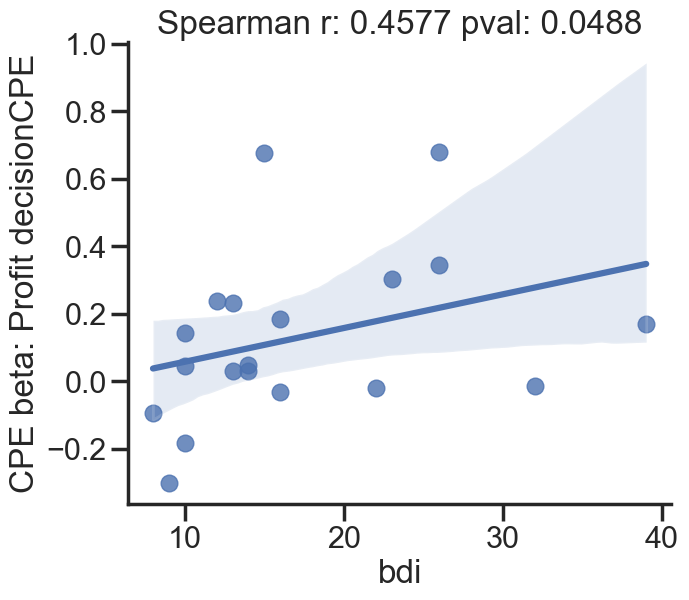

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


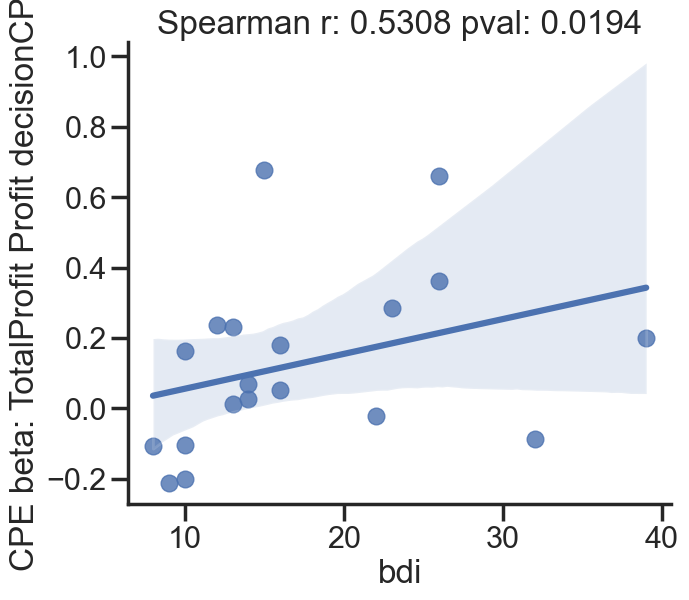

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


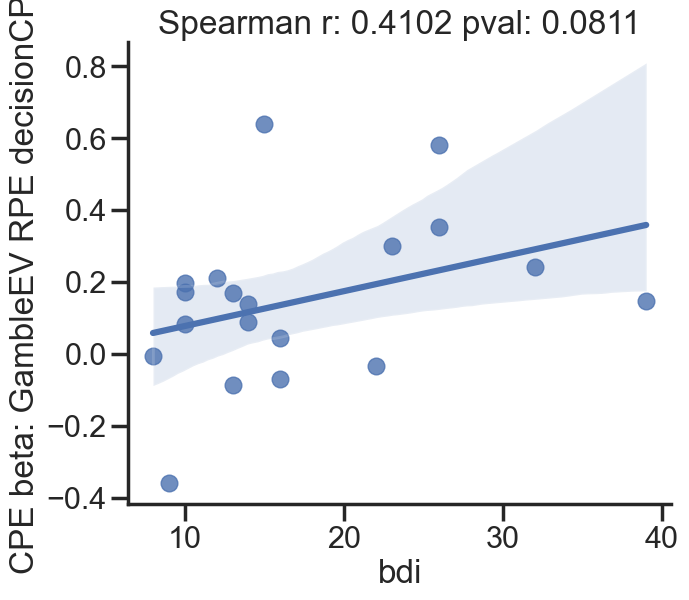

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


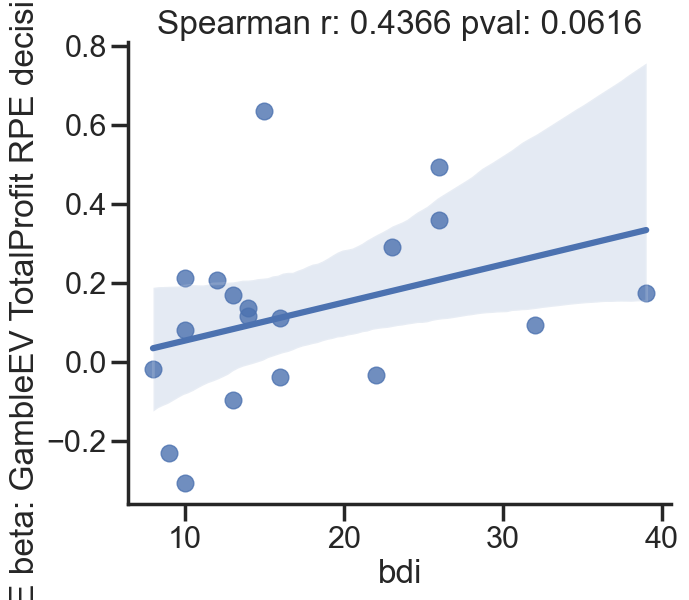

In [344]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

for model_id in trend_ids:
    model_df = model_param_dfs[model_id]
    
    # r,p = pearsonr(model_df.bdi,model_df.decisionCPE)
    r,p = spearmanr(model_df.bdi,model_df.decisionCPE)
    # t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
    # print(t,p_t)
    # fig = plt.scatter(model_df.bdi,model_df.decisionCPE)

    fig,ax = plt.subplots(figsize=(7,6))
    sns.regplot(data=model_df,x='bdi',y='decisionCPE',scatter=True)
    vars4title = model_df.model_id.unique()[0].split('_')
    plt.ylabel(f'CPE beta: {(" ").join(vars4title)}')
    plt.title(f'Spearman r: {np.round(r,4)} pval: {np.round(p,4)}')
    sns.despine()
    plt.show()



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


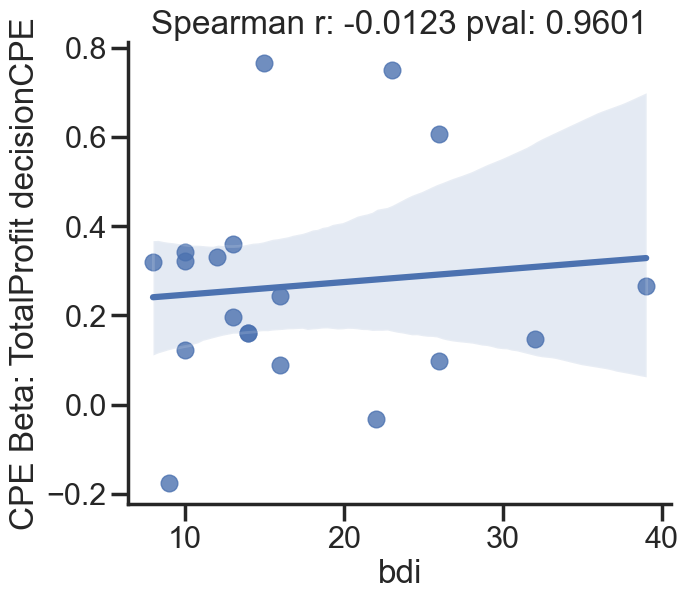

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


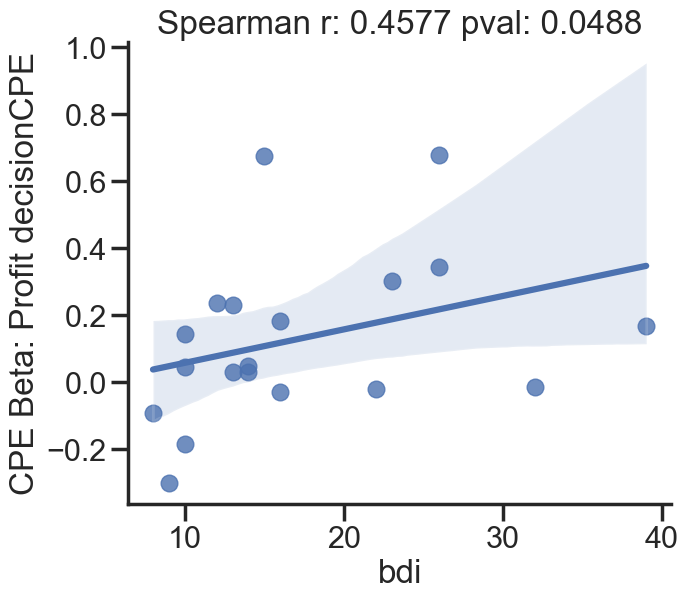

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


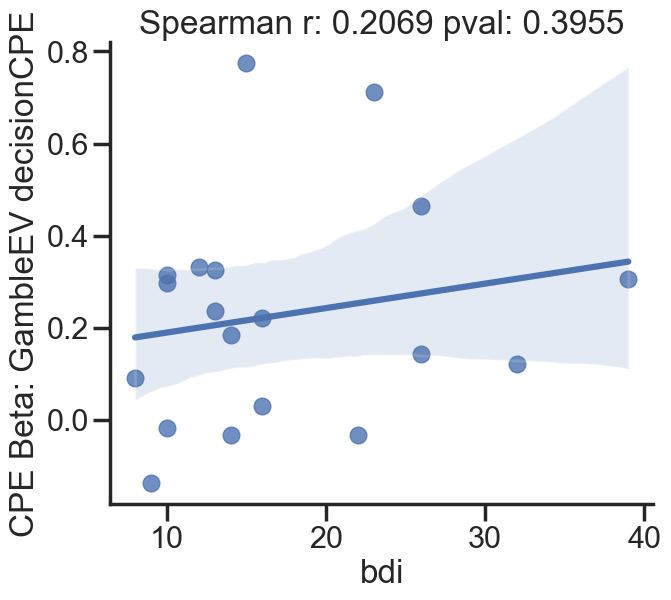

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


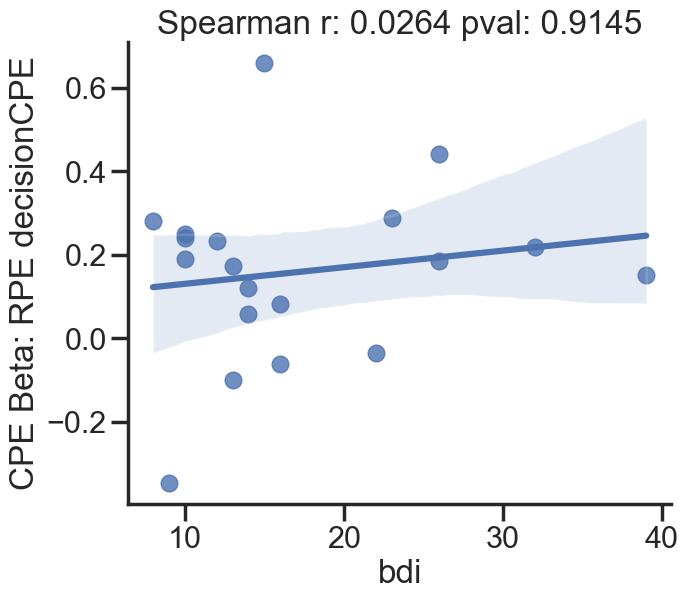

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


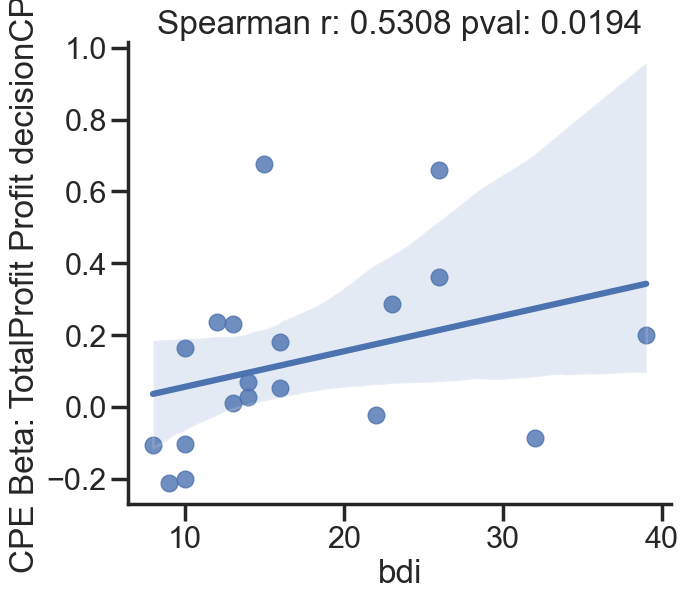

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


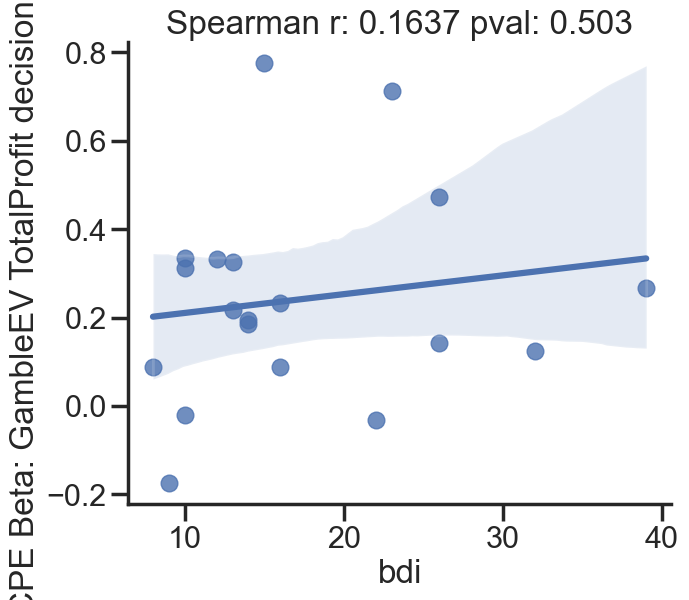

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


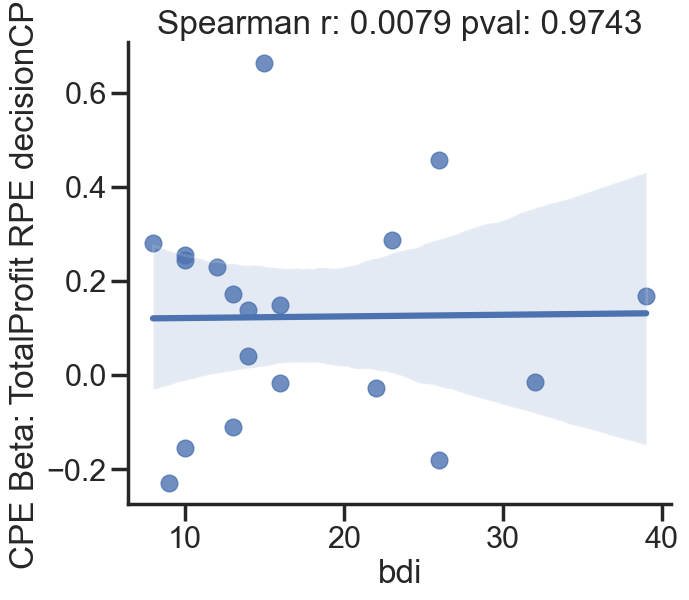

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


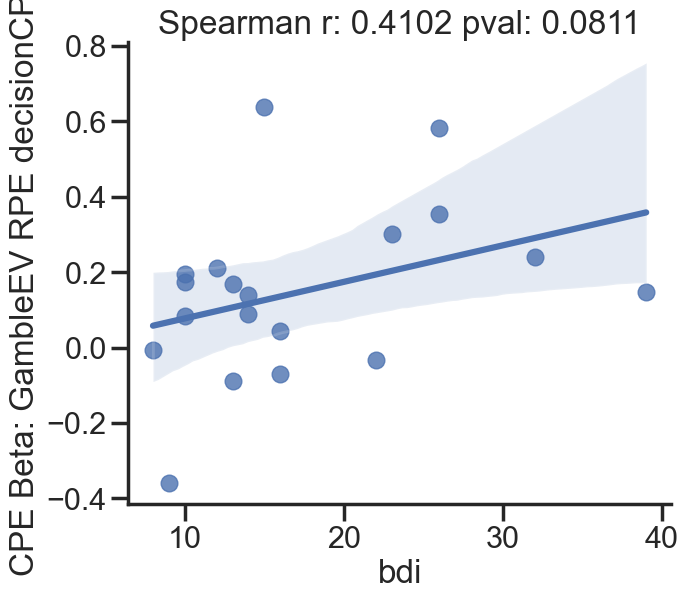

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


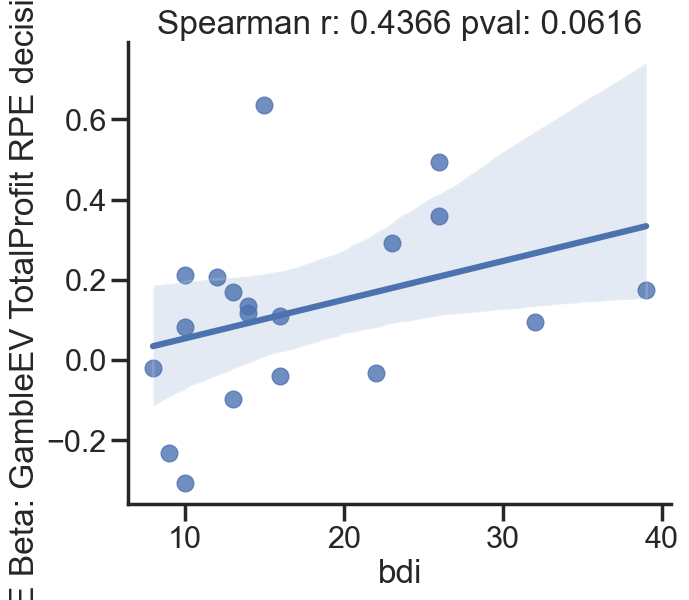

In [343]:
sig_models = []
for key in model_param_dfs.keys():
    model_df = model_param_dfs[key]
    
    r,p = spearmanr(model_df.bdi,model_df.decisionCPE)
    if p < 0.05:
        sig_models.append(model_df.model_id.unique())
    # t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
    # print(t,p_t)
    # print(model_df.model_id.unique(),r,p)
    # fig = plt.scatter(model_df.bdi,model_df.decisionCPE)
    fig,ax = plt.subplots(figsize=(7,6))
    sns.regplot(data=model_df,x='bdi',y='decisionCPE',scatter=True)
    vars4title = model_df.model_id.unique()[0].split('_')
    plt.ylabel(f'CPE Beta: {(" ").join(vars4title)}')
    plt.title(f'Spearman r: {np.round(r,4)} pval: {np.round(p,4)}')
    sns.despine()
    plt.show()



    # pearsonr()
    # model_df

In [345]:
sig_models

[array(['Profit_decisionCPE'], dtype=object),
 array(['TotalProfit_Profit_decisionCPE'], dtype=object)]

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

for model_id in trend_ids:
    model_df = model_param_dfs[model_id]
    
    # r,p = pearsonr(model_df.bdi,model_df.decisionCPE)
    r,p = spearmanr(model_df.bdi,model_df.decisionCPE)
    # t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
    # print(t,p_t)
    # fig = plt.scatter(model_df.bdi,model_df.decisionCPE)

    fig,ax = plt.subplots(figsize=(7,6))
    sns.regplot(data=model_df,x='bdi',y='decisionCPE',scatter=True)
    vars4title = model_df.model_id.unique()[0].split('_')
    plt.ylabel(f'CPE beta: {(" ").join(vars4title)}')
    plt.title(f'Spearman r: {np.round(r,4)} pval: {np.round(p,4)}')
    sns.despine()
    plt.show()

In [438]:
model_df = model_param_dfs['GambleEV_TotalProfit_RPE_decisionCPE']
    
# r,p = pearsonr(model_df.bdi,model_df.decisionCPE)
r,p = spearmanr(model_df.bdi,model_df.decisionCPE)
print(r,p)
# t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
# print(t,p_t)
# fig = plt.scatter(model_df.bdi,model_df.decisionCPE)

# fig,ax = plt.subplots(figsize=(7,6))
# sns.regplot(data=model_df,x='bdi',y='decisionCPE',scatter=True)
# vars4title = model_df.model_id.unique()[0].split('_')
# plt.ylabel(f'CPE beta: {(" ").join(vars4title)}')
# plt.title(f'Spearman r: {np.round(r,4)} pval: {np.round(p,4)}')
# sns.despine()
# plt.show()

0.43662242501350407Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 0.0616146723164272


In [442]:
spearmanr(model_df.bdi,model_df.GambleEV)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=-0.3494739974402442, pvalue=0.14248024194593242)

In [439]:
spearmanr(model_df.bdi,model_df.RPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=-0.24912126265891463, pvalue=0.3037121828014538)

In [440]:
spearmanr(model_df.bdi,model_df.TotalProfit)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=-0.14260651784715256, pvalue=0.560299396113592)

In [441]:
spearmanr(model_df.bdi,model_df.decisionCPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.43662242501350407, pvalue=0.0616146723164272)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


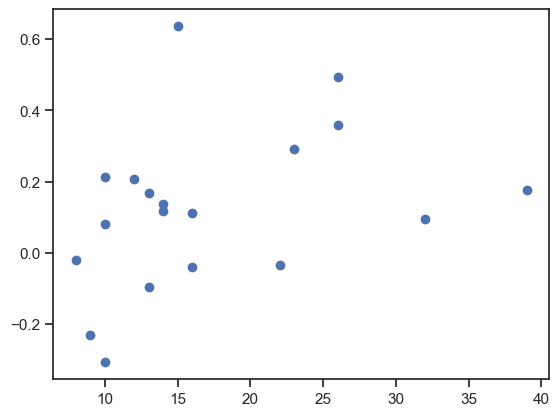

In [444]:
spearmanr(model_df.bdi,model_df.decisionCPE)
plt.scatter(model_df.bdi,model_df.decisionCPE)

In [432]:
depression_weights_plot = model_param_dfs['Profit_decisionCPE']
depression_weights_plot['Depression'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in depression_weights_plot.bdi]
depression_weights_plot

,subj_id,gamma,beta0,Profit,decisionCPE,model_id,bdi,Depressed,Depression
0,MS002,0.707308,0.011450,0.415805,0.029595,Profit_decisionCPE,14,Low BDI,Low BDI
1,MS003,1.000000,0.008513,0.260363,-0.093002,Profit_decisionCPE,8,Low BDI,Low BDI
2,MS009,0.625049,0.001101,0.135169,-0.030077,Profit_decisionCPE,16,Low BDI,Low BDI
3,MS011,0.373966,0.005489,0.299782,0.030056,Profit_decisionCPE,13,Low BDI,Low BDI
4,MS015,0.261065,0.044589,-0.525378,0.677623,Profit_decisionCPE,26,High BDI,High BDI
5,MS017,0.642986,-0.056907,0.232361,0.345805,Profit_decisionCPE,26,High BDI,High BDI
6,MS019,0.284728,0.031525,0.086356,0.238114,Profit_decisionCPE,12,Low BDI,Low BDI
7,MS022,0.125148,-0.012254,0.338774,0.045048,Profit_decisionCPE,10,Low BDI,Low BDI
8,MS024,0.122046,-0.018418,0.266676,0.183912,Profit_decisionCPE,16,Low BDI,Low BDI
9,MS025,0.845673,0.062440,0.783765,0.143634,Profit_decisionCPE,10,Low BDI,Low BDI


In [433]:
spearmanr(depression_weights_plot.bdi,depression_weights_plot.decisionCPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.4577493165464156, pvalue=0.048754896591230175)

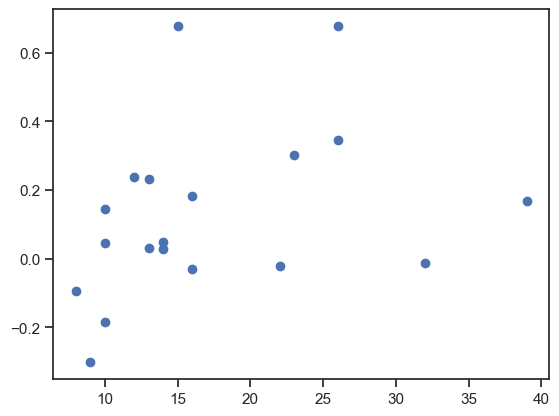

In [436]:
plt.scatter(depression_weights_plot.bdi,depression_weights_plot.decisionCPE)

In [356]:
t,p_t = ttest_ind(depression_weights_plot.decisionCPE[depression_weights_plot.bdi<20],depression_weights_plot.decisionCPE[depression_weights_plot.bdi>=20])
print(t,p_t)

-1.3616784147240402 0.19107372178228554


Text(0.5, 1.0, 'CPE')

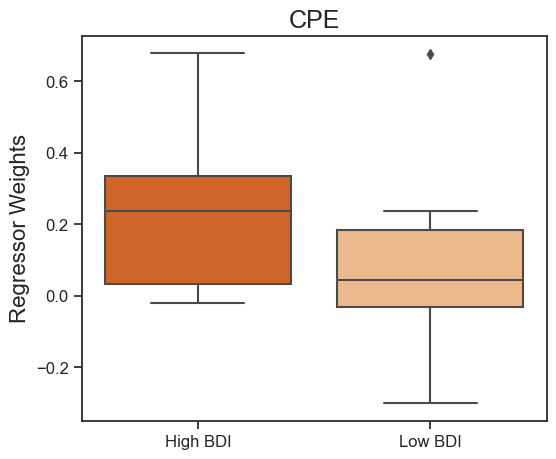

In [352]:
fig,ax1 = plt.subplots(1,1,figsize=(6,5))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot, x='Depression',y='decisionCPE',order=["High BDI", "Low BDI"],palette='Oranges_r')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('CPE',weight='medium',fontsize=18)

#fig.supylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
#fig.suptitle('Altered Emotional Sensitivity to \n Reward Signals in Depression',y=0.93,weight='semibold',fontsize=20)


In [430]:
depression_weights_plot2 = model_param_dfs['TotalProfit_Profit_decisionCPE']
depression_weights_plot2['Depression'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in depression_weights_plot2.bdi]
depression_weights_plot2

,subj_id,gamma,beta0,TotalProfit,Profit,decisionCPE,model_id,bdi,Depression
0,MS002,0.653121,0.008253,0.180671,0.429058,0.027931,TotalProfit_Profit_decisionCPE,14,Low BDI
1,MS003,1.000000,-0.045411,-0.069679,0.273934,-0.105810,TotalProfit_Profit_decisionCPE,8,Low BDI
2,MS009,1.000000,-0.008352,-0.311721,0.061538,0.051972,TotalProfit_Profit_decisionCPE,16,Low BDI
3,MS011,0.361318,0.011105,0.067141,0.300194,0.012109,TotalProfit_Profit_decisionCPE,13,Low BDI
4,MS015,0.285809,-0.101966,-0.184731,-0.523127,0.660716,TotalProfit_Profit_decisionCPE,26,High BDI
5,MS017,0.633262,-0.022168,-0.020158,0.226642,0.360916,TotalProfit_Profit_decisionCPE,26,High BDI
6,MS019,0.283507,0.022395,0.006215,0.086893,0.237197,TotalProfit_Profit_decisionCPE,12,Low BDI
7,MS022,0.000100,-0.118992,0.758714,0.456952,-0.104153,TotalProfit_Profit_decisionCPE,10,Low BDI
8,MS024,0.161252,-0.292668,0.429004,0.220777,0.180487,TotalProfit_Profit_decisionCPE,16,Low BDI
9,MS025,0.762519,0.184268,0.293600,0.817772,0.163034,TotalProfit_Profit_decisionCPE,10,Low BDI


In [431]:
spearmanr(depression_weights_plot2.bdi,depression_weights_plot2.decisionCPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.5308131497644012, pvalue=0.019369896623294313)

In [435]:
spearmanr(depression_weights_plot2.bdi,depression_weights_plot2.Profit)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=-0.3186639472880816, pvalue=0.18361545983915173)

In [358]:
t,p_t = ttest_ind(depression_weights_plot2.decisionCPE[depression_weights_plot2.bdi<20],depression_weights_plot2.decisionCPE[depression_weights_plot2.bdi>=20])
print(t,p_t)



-1.2702787540167473 0.2210964137650665


Text(0.5, 1.0, 'CPE')

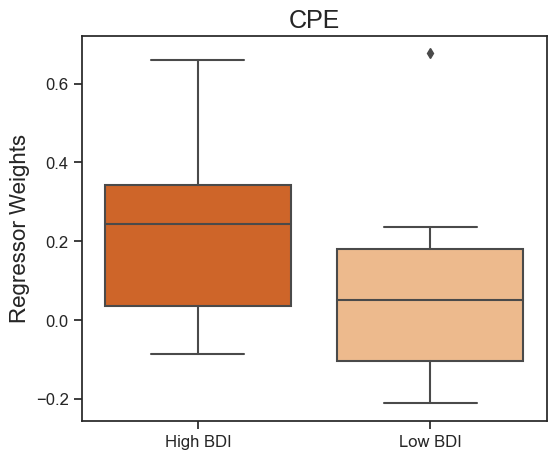

In [359]:
fig,ax1 = plt.subplots(1,1,figsize=(6,5))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot2, x='Depression',y='decisionCPE',order=["High BDI", "Low BDI"],palette='Oranges_r')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('CPE',weight='medium',fontsize=18)

In [360]:
depression_weights_plot

,subj_id,gamma,beta0,Profit,decisionCPE,model_id,bdi,Depressed,Depression
0,MS002,0.707308,0.011450,0.415805,0.029595,Profit_decisionCPE,14,Low BDI,Low BDI
1,MS003,1.000000,0.008513,0.260363,-0.093002,Profit_decisionCPE,8,Low BDI,Low BDI
2,MS009,0.625049,0.001101,0.135169,-0.030077,Profit_decisionCPE,16,Low BDI,Low BDI
3,MS011,0.373966,0.005489,0.299782,0.030056,Profit_decisionCPE,13,Low BDI,Low BDI
4,MS015,0.261065,0.044589,-0.525378,0.677623,Profit_decisionCPE,26,High BDI,High BDI
5,MS017,0.642986,-0.056907,0.232361,0.345805,Profit_decisionCPE,26,High BDI,High BDI
6,MS019,0.284728,0.031525,0.086356,0.238114,Profit_decisionCPE,12,Low BDI,Low BDI
7,MS022,0.125148,-0.012254,0.338774,0.045048,Profit_decisionCPE,10,Low BDI,Low BDI
8,MS024,0.122046,-0.018418,0.266676,0.183912,Profit_decisionCPE,16,Low BDI,Low BDI
9,MS025,0.845673,0.062440,0.783765,0.143634,Profit_decisionCPE,10,Low BDI,Low BDI


Text(0.5, 1.0, 'CPE')

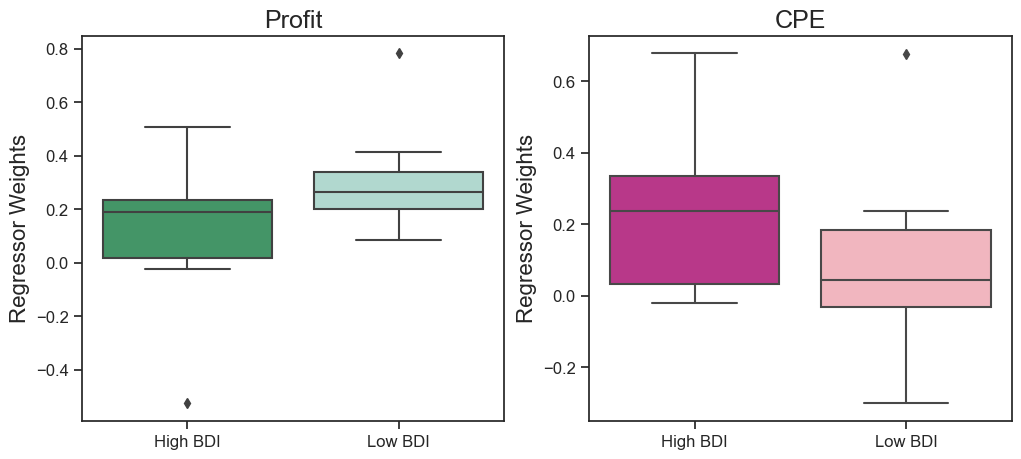

In [366]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot, x='Depression',y='Profit',order=["High BDI", "Low BDI"],palette='BuGn_r')
sns.boxplot(ax=ax2,data=depression_weights_plot, x='Depression',y='decisionCPE',order=["High BDI", "Low BDI"],palette='RdPu_r')


#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Profit',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax2.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('CPE',weight='medium',fontsize=18)




In [367]:
model_param_dfs.keys()

dict_keys(['TotalProfit_decisionCPE', 'Profit_decisionCPE', 'GambleEV_decisionCPE', 'RPE_decisionCPE', 'TotalProfit_Profit_decisionCPE', 'GambleEV_TotalProfit_decisionCPE', 'TotalProfit_RPE_decisionCPE', 'GambleEV_RPE_decisionCPE', 'GambleEV_TotalProfit_RPE_decisionCPE'])

In [368]:
depression_weights_plot3 = model_param_dfs['GambleEV_TotalProfit_RPE_decisionCPE']
depression_weights_plot3['Depression'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in depression_weights_plot3.bdi]
depression_weights_plot3

,subj_id,gamma,beta0,GambleEV,TotalProfit,RPE,decisionCPE,model_id,bdi,Depression
0,MS002,0.822206,0.000991,0.304619,0.112222,0.177962,0.135862,GambleEV_TotalProfit_RPE_decisionCPE,14,Low BDI
1,MS003,1.000000,-0.047094,0.218286,-0.084470,0.128944,-0.019066,GambleEV_TotalProfit_RPE_decisionCPE,8,Low BDI
2,MS009,0.000100,-0.003776,-0.112677,-0.954562,0.274094,-0.038771,GambleEV_TotalProfit_RPE_decisionCPE,16,Low BDI
3,MS011,0.606703,0.007573,0.075562,0.048063,0.379585,-0.097151,GambleEV_TotalProfit_RPE_decisionCPE,13,Low BDI
4,MS015,0.285612,-0.062738,-0.360608,-0.178382,-0.250511,0.493083,GambleEV_TotalProfit_RPE_decisionCPE,26,High BDI
5,MS017,0.671697,-0.020550,0.155577,-0.007984,0.142061,0.360014,GambleEV_TotalProfit_RPE_decisionCPE,26,High BDI
6,MS019,0.309180,0.013551,0.020161,0.015193,0.098845,0.207152,GambleEV_TotalProfit_RPE_decisionCPE,12,Low BDI
7,MS022,0.000100,-0.091921,0.252135,0.849148,0.527146,-0.306499,GambleEV_TotalProfit_RPE_decisionCPE,10,Low BDI
8,MS024,0.265188,-0.210698,-0.096194,0.358637,0.342316,0.110491,GambleEV_TotalProfit_RPE_decisionCPE,16,Low BDI
9,MS025,0.804682,0.091534,0.387313,0.207070,0.434615,0.211702,GambleEV_TotalProfit_RPE_decisionCPE,10,Low BDI


In [374]:
spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.43662242501350407, pvalue=0.0616146723164272)

In [384]:
_,p= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)
print(p)


0.0616146723164272Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'CPE Spearman R:0.437 P:0.062')

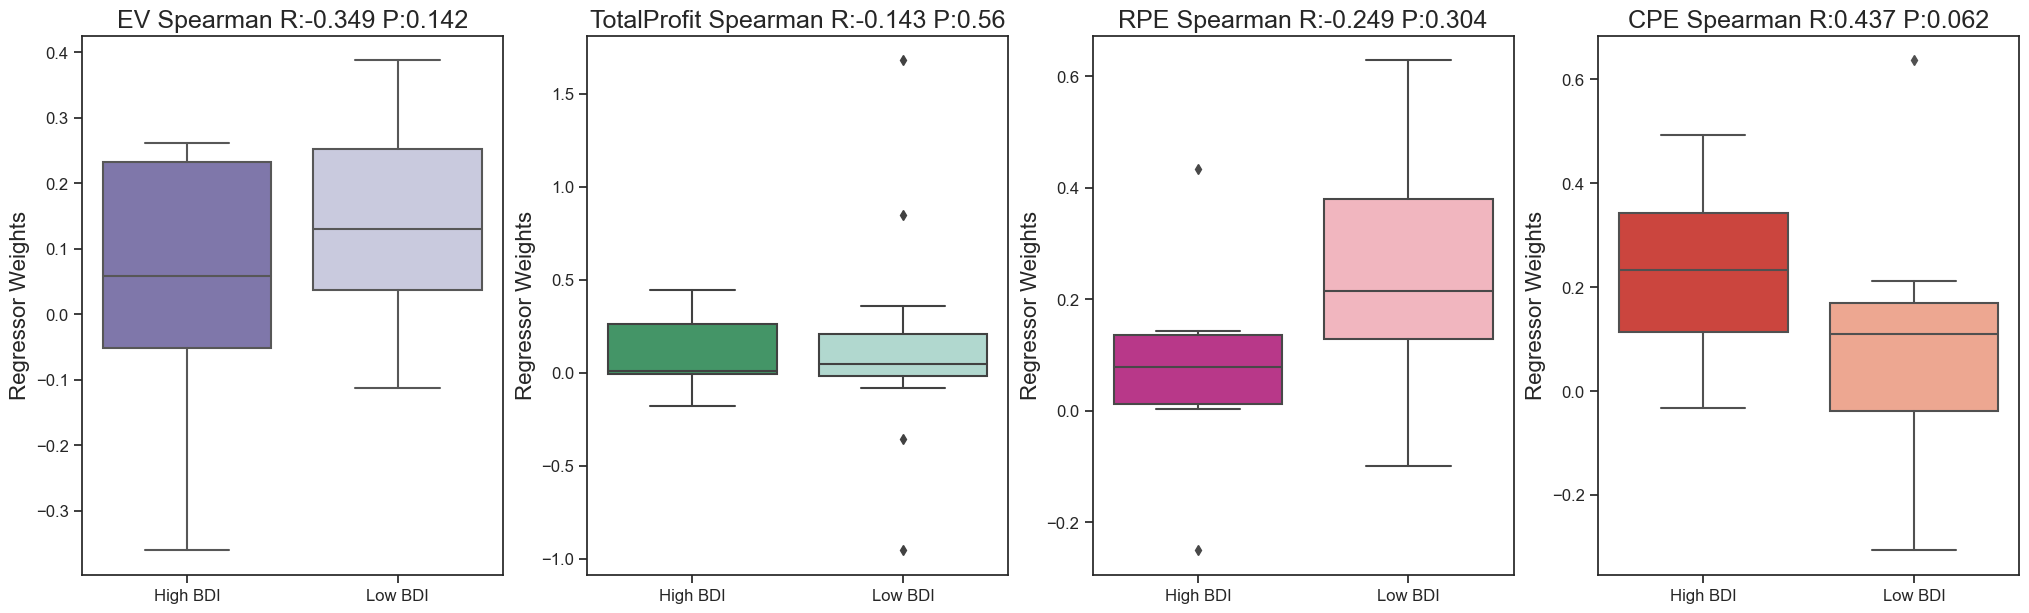

In [419]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,7))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot3, x='Depression',y='GambleEV',order=["High BDI", "Low BDI"],palette='Purples_r')
sns.boxplot(ax=ax2,data=depression_weights_plot3, x='Depression',y='TotalProfit',order=["High BDI", "Low BDI"],palette='BuGn_r')
sns.boxplot(ax=ax3,data=depression_weights_plot3, x='Depression',y='RPE',order=["High BDI", "Low BDI"],palette='RdPu_r')
sns.boxplot(ax=ax4,data=depression_weights_plot3, x='Depression',y='decisionCPE',order=["High BDI", "Low BDI"],palette='Reds_r')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
r1,p1= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.GambleEV)
ax1.set_title(f'EV Spearman R:{np.round(r1,3)} P:{np.round(p1,3)}',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax2.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
r2,p2= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.TotalProfit)
ax2.set_title( f'TotalProfit Spearman R:{np.round(r2,3)} P:{np.round(p2,3)}',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax3.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
r3,p3= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.RPE)
ax3.set_title(f'RPE Spearman R:{np.round(r3,3)} P:{np.round(p3,3)}',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax4.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax4.set_xlabel(None)
ax4.tick_params(labelsize=12)
r4,p4= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)
ax4.set_title(f'CPE Spearman R:{np.round(r4,3)} P:{np.round(p4,3)}',weight='medium',fontsize=18)



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


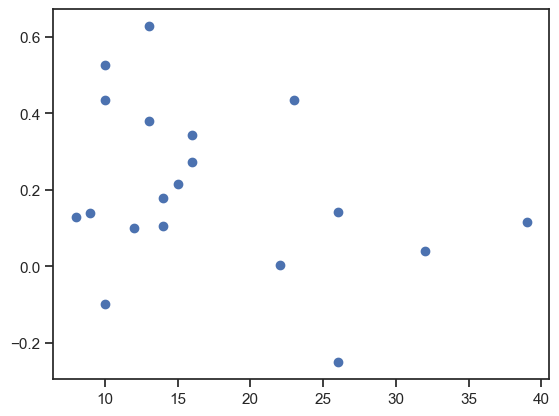

In [426]:
spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.RPE)
plt.scatter(depression_weights_plot3.bdi,depression_weights_plot3.RPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


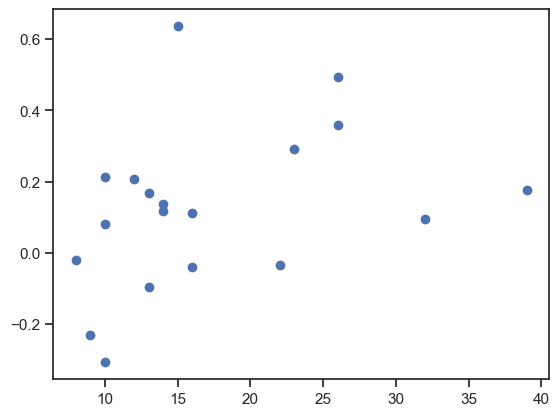

In [429]:
spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)
plt.scatter(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)